In [1]:
import sys

sys.path.append('../')

In [2]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [3]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.vocab import *
from mrl.callbacks import *
from mrl.callbacks.template_cb import *
from mrl.agent import *
from mrl.policy_gradient import *
from mrl.loss import *
from mrl.sampler import *
from mrl.environment import *
from mrl.reward import *

In [4]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(0)
set_global_pool(cpus=8)

In [5]:
class DQNDataset(Base_Dataset):
    def __init__(self, samples, fp_function, collate_function):
        super().__init__(collate_function)
        
        self.samples = samples
        self.fp_function = fp_function
        
    def __len__(self):
        return len(self.samples)
    
    def get_state_fps(self, state, steps_left):
        fp = fp_to_array(self.fp_function(state))
        fp = np.append(fp, steps_left)
        return torch.tensor(fp).float()
    
    def get_next_state_fps(self, next_states, steps_left):
        next_fps = [fp_to_array(self.fp_function(i)) for i in next_states]
        next_fps = np.stack([np.append(i, steps_left-1) for i in next_fps])
        return torch.tensor(next_fps).float()
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        smile, steps_left, next_states = sample
        fp = self.get_state_fps(smile, steps_left)
        next_fps = self.get_next_state_fps(next_states, steps_left-1)
        
        return fp, next_fps
    
    def new(self, samples):
        return self.__class__(samples, self.fp_function, self.collate_function)
    
    def split_on_idxs(self, train_idxs, valid_idxs):
        
        train_ds = self.new([self.samples[i] for i in train_idxs])
        valid_ds = self.new([self.samples[i] for i in valid_idxs])
        return (train_ds, valid_ds)
        
    
def moldqn_collate(batch):
    fps = torch.stack([i[0] for i in batch])
    
    y_size = max([i[1].shape[0] for i in batch])
    y_block = torch.zeros((len(batch), y_size, fps.shape[-1]))-1
    
    nfps = [i[1] for i in batch]
    for i, nfp in enumerate(nfps):
        num_fps = nfp.shape[0]
        y_block[i, :num_fps] = nfp

    return fps, y_block

In [6]:
samples = []
state = 'CCC'

steps_left = 20
for i in range(10):

    new_states = add_bond_combi(state) + add_atom_combi(state, ['C', 'N', 'O', -1, -2]) + [state]
    new_states = list(set(new_states))
    new_states = [i for i in new_states if i is not None and not '.' in i]
    samples.append((state, steps_left-i, tuple(new_states)))
    state = np.random.choice(new_states)

In [7]:
ds = DQNDataset(samples, ECFP6, moldqn_collate)

In [8]:
model = MLP_Encoder(2049, [1024, 512, 256, 128], 1, [0.1, 0.1, 0.1, 0.1])

In [9]:
class DQNAgent(BaselineAgent):
    def __init__(self, model, dataset, discount,
                 gamma,
                base_update=0.99, base_update_iter=5,
                opt_kwargs={}, clip=1., name='DQN'):
        super().__init__(model=model, 
                         loss_function=None, 
                         dataset=dataset, 
                         base_update=base_update,
                         base_update_iter=base_update_iter, 
                         base_model=True, 
                         opt_kwargs=opt_kwargs, 
                         clip=clip, 
                         name=name)
        
        self.discount = discount
        self.gamma = gamma
  
    def setup(self):
        log = self.environment.log
        log.add_metric('dqn_loss')
        log.add_log('dqn_loss')
        
        log.add_metric('dqn_reward')
        log.add_log('dqn_reward')
        
        log.add_log('full_samples')
        log.add_log('steps_left')
    
    def before_compute_reward(self):
        env = self.environment
        batch_state = env.batch_state
        samples = batch_state.samples
 
        batch_ds = self.dataset.new(samples)
        batch = batch_ds.collate_function([batch_ds[i] for i in range(len(batch_ds))])
        batch = to_device(batch)
        bs = len(batch_ds)
        x,y = batch
            
        batch_state.x = x
        batch_state.y = y
        batch_state.bs = bs
        batch_state.rewards = to_device(torch.zeros(bs))
        batch_state.full_samples = samples
        batch_state.steps_left = x[:,-1]
        batch_state.samples = [i[0] for i in samples]
        
    def reward_modification(self):
        env = self.environment
        batch_state = env.batch_state
        
        x = batch_state.x
        steps_left = x[:,-1]
        batch_state.rewards_final = batch_state.rewards_final * self.discount ** (steps_left)
        
        batch_state['dqn_reward'] = batch_state.rewards_final
        
        env.log.update_metric('dqn_reward', 
                              batch_state.rewards_final.mean().detach().cpu().numpy())
        
    def compute_loss(self):
        env = self.environment
        batch_state = env.batch_state
        
        x = batch_state.x
        y = batch_state.y
        
        steps_left = x[:,-1]
        reward = batch_state.rewards_final
        dones = steps_left<=0
        
        with torch.no_grad():
            
            bs,num_fps,dim = y.shape
            preds = self.base_model(y.view(-1, dim)).view(bs,num_fps)
            mask = ((y==-1).sum(-1))==0
            actions = preds.masked_fill(~mask, float('-inf')).argmax(-1)
            
        act_fps = y[torch.arange(bs), actions]
        
        v_pred = self.model(x).squeeze()
        
        with torch.no_grad():
            v_t1_pred = self.base_model(act_fps).squeeze()
            
        v_target = reward + self.gamma*v_t1_pred*(1-dones.float())
        v_error = v_pred - v_target

        loss = torch.where(
            torch.abs(v_error) < 1.0,
            0.5 * v_error * v_error,
            1.0 * (torch.abs(v_error) - 0.5),
        )
        
        
        self.environment.batch_state.loss += loss.mean()
        self.environment.batch_state['dqn_loss'] = loss.detach().cpu().numpy()
        env.log.update_metric('dqn_loss', 
                              loss.mean().detach().cpu().numpy())

In [10]:
agent = DQNAgent(model, 
                 ds, 
                 0.98,
                 .995, 
                 base_update=0.995, 
                 base_update_iter=1,
                 opt_kwargs={'lr':1e-3}, 
                 clip=1.)

In [11]:
class DQNSampler(Sampler):
    def __init__(self, agent, buffer_size, eps, min_eps, max_steps=40):
        super().__init__('dqn_sampler', buffer_size=buffer_size)
        
        self.agent = agent
        self.transition_dict = {}
        self.starting_states = ['C', 'N', 'O']
        self.atom_types = ['C', 'N', 'O', -1, -2]
        self.eps = eps
        self.min_eps = min_eps
        self.max_steps = max_steps
                 
        
    def build_buffer(self):
        
        buffer_items = []
        while len(buffer_items) < self.buffer_size:
            buffer_items += self.build_episode('C', self.max_steps)

        if buffer_items:
            self.environment.buffer.add(buffer_items, self.name)
        
        
    def build_episode(self, state, steps_left):

        buffer_items = []
        starting_step = self.max_steps - steps_left
        
        for i in range(starting_step, self.max_steps):
            steps_left = self.max_steps - i
            new_states = self.get_new_states(state)
            buffer_items.append((state, steps_left, new_states))
            
            if len(new_states)>1:
                new_fps = self.agent.dataset.get_next_state_fps(new_states, steps_left)

                with torch.no_grad():
                    new_fps = to_device(new_fps).float()
                    values = self.agent.base_model(new_fps)

                self.eps = max(self.eps, self.min_eps)

                if np.random.uniform() < self.eps:
                    action = np.random.randint(0, values.shape[0])
                else:
                    action = values.argmax()

                state = new_states[action]
            else:
                break
            
        self.eps *= 0.99907
        return buffer_items
        
    def get_new_states(self, state):
        
        if state in self.transition_dict.keys():
            clean_states = self.transition_dict[state]
        else:
            new_states = add_bond_combi(state) + add_atom_combi(state, self.atom_types) + [state]
            new_states = list(set(new_states))
            clean_states = []
            for ns in new_states:
                if (ns is not None) and (not '.' in ns) and (len(ns)>0):
                    clean_states.append(ns)
                    
            clean_states = tuple(clean_states)
            self.transition_dict[state] = clean_states
            
        return clean_states
    
class DQNDatasetSampler(DQNSampler):
    def __init__(self, agent, states, buffer_size, eps, min_eps, max_steps=40):
        super().__init__(agent, buffer_size, eps, min_eps, max_steps)
        
        self.states = states
        
    def build_buffer(self):
        
        buffer_items = []
        while len(buffer_items) < self.buffer_size:
            state = np.random.choice(self.states)
            buffer_items += self.build_episode(state, self.max_steps)

        if buffer_items:
            self.environment.buffer.add(buffer_items, self.name)
    
class DQNLogSampler(DQNSampler):
    def __init__(self, agent, percentile, lookup_name, 
                 buffer_size, eps, min_eps, max_steps=40):
        super().__init__(agent, buffer_size, eps, min_eps, max_steps)
        self.percentile = percentile
        self.lookup_name = lookup_name
        
    def build_buffer(self):
        
        df = self.environment.log.df
        
        if df.shape[0]>100:
            df = df[df[self.lookup_name]>np.percentile(df[self.lookup_name].values, self.percentile)]

            buffer_items = []
            while len(buffer_items) < self.buffer_size:

                sample = df.sample(n=1)
                state = sample.samples.values[0]
                steps = int(sample.steps_left.values[0])

                buffer_items += self.build_episode(state, steps)

            if buffer_items:
                self.environment.buffer.add(buffer_items, self.name)
        
        

In [12]:
# sampler1 = DQNSampler(agent, 500, 0.999, 0.05, max_steps=40)
df = next(pd.read_csv('/home/dmai/smiles_datasets/shard_0.csv', chunksize=100000))

sampler1 = DQNDatasetSampler(agent, df.smiles.values, 500, 0.999, 0.05, max_steps=10)
sampler2 = LogSampler('full_samples', 'rewards', 10, 95, 100)
sampler3 = DQNLogSampler(agent, 95, 'rewards', 100, 0.999, 0.05, max_steps=10)

samplers = [sampler1, sampler2, sampler3]

In [13]:
class DQNTemplate(TemplateCallback):
    def __init__(self, template=None, weight=1., track=True, prefilter=True):
        super().__init__(template, weight, track, prefilter)
        
    def filter_buffer(self):
        pass
                
    def filter_batch(self):
        if self.track:
            env.log.update_metric('valid', 1.)

In [14]:
def scale_sa(sa):
    return (10-sa)/9

# template = Template([ValidityFilter(), 
#                      SingleCompoundFilter()],
#                     [QEDFilter(None, None, score=PassThroughScore()),
#                      SAFilter(None, None, score=PropertyFunctionScore(scale_sa))], 
#                     fail_score=-1., log=False)

template = Template([ValidityFilter(), 
                     SingleCompoundFilter()],
                    [QEDFilter(None, None, score=PassThroughScore())], 
                    fail_score=-1., log=False)

template_cb = DQNTemplate(template, prefilter=False)

In [15]:
class PathLength(Callback):
    def __init__(self):
        super().__init__(name='avg_steps_left')
        
    def setup(self):
        log = self.environment.log
        log.add_metric(self.name)
        
    def after_compute_reward(self):
        log = self.environment.log
        x = self.environment.batch_state.x
        env.log.update_metric(self.name, x[:,-1].mean().detach().cpu().numpy())

In [16]:
live_max = MaxCallback('rewards', None)
live_p90 = PercentileCallback('rewards', None, 90)
pl_cb = PathLength()

cbs = [live_p90, live_max, pl_cb]

In [17]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[], loss_cbs=[],
                 cbs=cbs)

In [18]:
set_global_pool(cpus=8)

In [19]:
env.fit(64, 25, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,dqn_loss,dqn_reward,avg_steps_left,rewards_p90,rewards_max
0,0.549,0.483,1.000,1.000,64,0.549,1.000,0.293,0.483,5.922,0.839,0.904
10,0.607,0.540,1.000,1.000,64,0.607,1.000,0.138,0.540,5.562,0.783,0.868
20,0.648,0.580,1.000,1.000,64,0.648,1.000,0.113,0.580,5.344,0.844,0.927
30,0.615,0.554,1.000,1.000,64,0.615,1.000,0.099,0.554,5.109,0.859,0.899
40,0.632,0.565,1.000,1.000,64,0.632,1.000,0.091,0.565,5.312,0.821,0.891
50,0.645,0.573,1.000,1.000,64,0.645,1.000,0.070,0.573,5.531,0.878,0.945
60,0.678,0.600,1.000,1.000,64,0.678,1.000,0.079,0.600,5.812,0.869,0.933
70,0.648,0.578,1.000,1.000,64,0.648,1.000,0.047,0.578,5.406,0.866,0.906
80,0.676,0.595,1.000,1.000,64,0.676,1.000,0.087,0.595,5.984,0.906,0.935
90,0.666,0.592,1.000,1.000,64,0.666,1.000,0.049,0.592,5.484,0.887,0.916


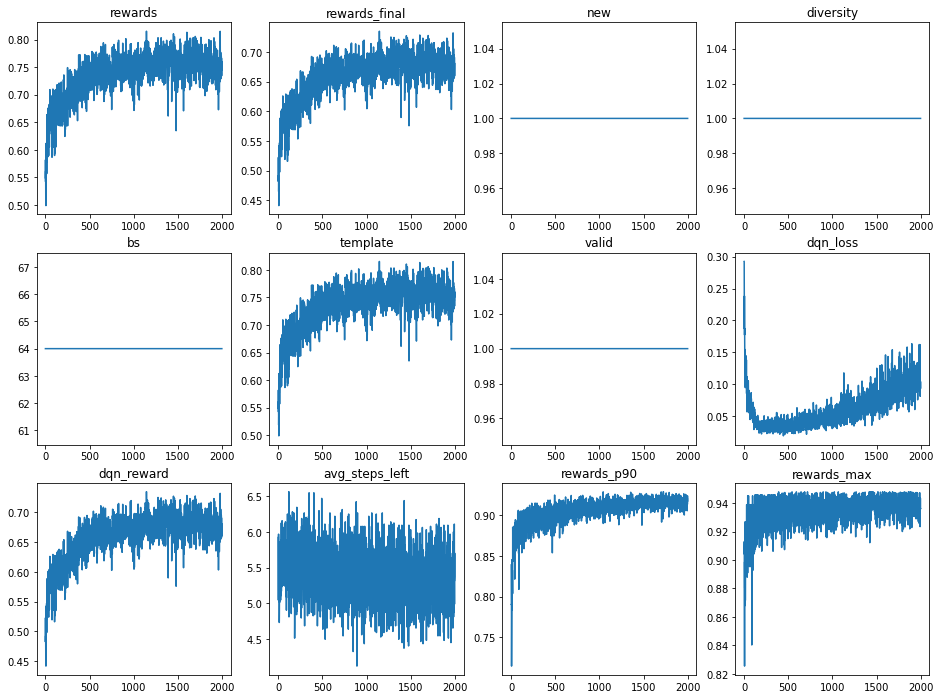

In [20]:
env.log.plot_metrics()

In [19]:
env.fit(64, 25, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,dqn_loss,dqn_reward,avg_steps_left,rewards_p90,rewards_max
0,0.262,0.045,1.000,1.000,64,0.262,1.000,0.111,0.045,20.109,0.374,0.510
10,0.295,0.064,1.000,1.000,64,0.295,1.000,0.079,0.064,19.719,0.430,0.542
20,0.335,0.084,1.000,1.000,64,0.335,1.000,0.098,0.084,18.516,0.555,0.579
30,0.288,0.075,1.000,1.000,64,0.288,1.000,0.070,0.075,17.500,0.520,0.605
40,0.347,0.119,1.000,1.000,64,0.347,1.000,0.077,0.119,14.797,0.600,0.714
50,0.354,0.102,1.000,1.000,64,0.354,1.000,0.060,0.102,16.500,0.542,0.660
60,0.303,0.089,1.000,1.000,64,0.303,1.000,0.033,0.089,18.766,0.507,0.698
70,0.368,0.086,1.000,1.000,64,0.368,1.000,0.061,0.086,19.094,0.568,0.736
80,0.296,0.074,1.000,1.000,64,0.296,1.000,0.043,0.074,18.312,0.468,0.542
90,0.307,0.075,1.000,1.000,64,0.307,1.000,0.030,0.075,17.781,0.507,0.680


In [30]:
sampler2.percentile = 97
sampler3.percentile = 97
refresh_global_pool()

In [31]:
env.fit(64, 25, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,dqn_loss,dqn_reward,avg_steps_left,rewards_p90,rewards_max
2000,0.675,0.284,1.000,1.000,64,0.675,1.000,0.034,0.284,11.734,0.880,0.924
2010,0.655,0.285,1.000,1.000,64,0.655,1.000,0.015,0.285,12.891,0.853,0.922
2020,0.641,0.263,1.000,1.000,64,0.641,1.000,0.021,0.263,12.844,0.859,0.918
2030,0.643,0.291,1.000,1.000,64,0.643,1.000,0.031,0.291,11.641,0.838,0.905
2040,0.712,0.322,1.000,1.000,64,0.712,1.000,0.031,0.322,10.906,0.869,0.912
2050,0.680,0.289,1.000,1.000,64,0.680,1.000,0.035,0.289,12.594,0.861,0.919
2060,0.673,0.251,1.000,1.000,64,0.673,1.000,0.021,0.251,14.609,0.888,0.921
2070,0.641,0.270,1.000,1.000,64,0.641,1.000,0.023,0.270,13.969,0.870,0.920
2080,0.669,0.302,1.000,1.000,64,0.669,1.000,0.018,0.302,12.078,0.858,0.922
2090,0.671,0.259,1.000,1.000,64,0.671,1.000,0.020,0.259,12.766,0.863,0.916


In [32]:
env.fit(64, 25, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,dqn_loss,dqn_reward,avg_steps_left,rewards_p90,rewards_max
4000,0.689,0.251,1.000,1.000,64,0.689,1.000,0.053,0.251,15.391,0.912,0.927
4010,0.715,0.314,1.000,1.000,64,0.715,1.000,0.074,0.314,12.984,0.913,0.941
4020,0.699,0.300,1.000,1.000,64,0.699,1.000,0.060,0.300,12.797,0.895,0.942
4030,0.738,0.288,1.000,1.000,64,0.738,1.000,0.117,0.288,14.406,0.906,0.931
4040,0.698,0.265,1.000,1.000,64,0.698,1.000,0.090,0.265,14.766,0.908,0.929
4050,0.718,0.333,1.000,1.000,64,0.718,1.000,0.090,0.333,12.906,0.917,0.935
4060,0.660,0.225,1.000,1.000,64,0.660,1.000,0.126,0.225,15.547,0.909,0.930
4070,0.673,0.253,1.000,1.000,64,0.673,1.000,0.104,0.253,14.375,0.892,0.925
4080,0.706,0.297,1.000,1.000,64,0.706,1.000,0.065,0.297,12.812,0.911,0.928
4090,0.691,0.274,1.000,1.000,64,0.691,1.000,0.072,0.274,14.453,0.883,0.936


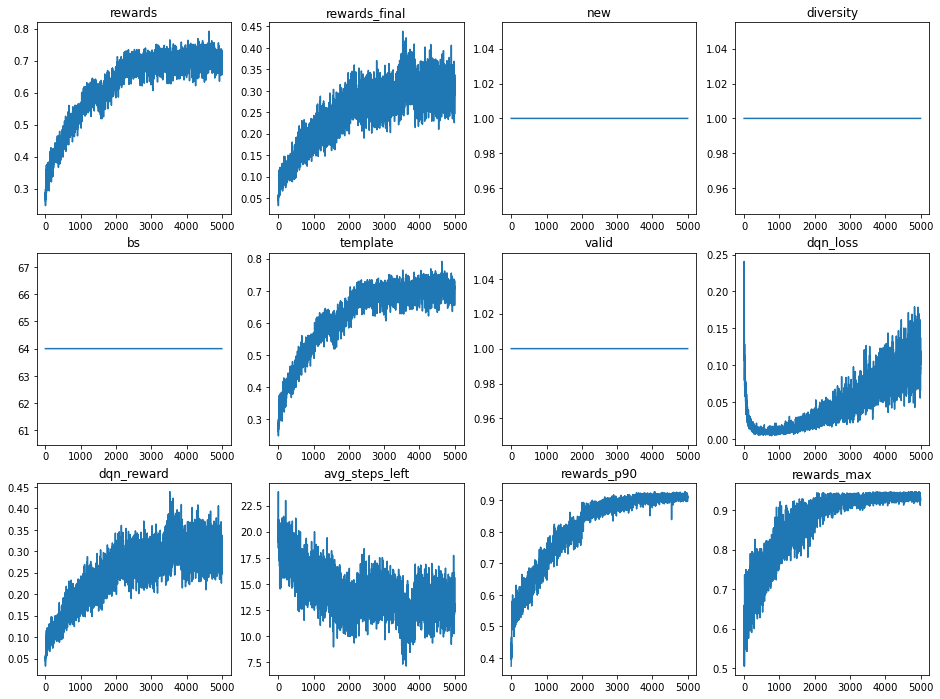

In [33]:
env.log.plot_metrics()

In [42]:
env.log.df[env.log.df.rewards>0.947]

,samples,sources,rewards,rewards_final,template,dqn_loss,dqn_reward,full_samples,steps_left
111378,CCCC12N=NCC34CC1c1c(OC)c(c5nc1c(cc53)N2)=N4,dqn_sampler_buffer,0.947308,0.453094,0.947308,0.037506,0.453094,"(CCCC12N=NCC34CC1c1c(OC)c(c5nc1c(cc53)N2)=N4, ...",7.0
115175,CCCOc1c2oc3c1C(=C=NCO2)C1c2cc4c([nH]2)CCC431,dqn_sampler_buffer,0.947316,0.690593,0.947316,0.100588,0.690593,"(CCCOc1c2oc3c1C(=C=NCO2)C1c2cc4c([nH]2)CCC431,...",3.0


sampler
    does rollout
    adds (state, reward, steps left) to buffer
    
agent
    get model outputs
        get all possible new states
        predict values with tarrgte model
        
loss
    DQN target model loss
    
    
    
    
    
build buffer
    rollout samples (state, stps left) into buffr
   
sample batch
    sample from buffer, no live
    
compute rewards
    get rewards for sample
    
get model outputs
    get new states for samples
    use target model to select new states
    add vt_pred, vt1_pred, dones to batch state
    
compute loss
    DQN loss
    
to think about
    before_compute_reward